<a href="https://colab.research.google.com/github/janpeter19/BPL_CHO_Perfusion/blob/main/Notes_BPL_CHO_Perfusion_cspr_opennloop_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_CHO_Perfusion_cspr_openloop script with PyFMI

The key library PyFMI is installed.

After the installation a small application BPL_CHO_Pefusion_cspr_openloop is loaded and run. You can continue with this example if you like.

In [ ]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
!chmod +x Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
!bash ./Miniconda3-py310_23.1.0-1-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')

--2024-05-24 11:04:25--  https://repo.anaconda.com/miniconda/Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74403966 (71M) [application/x-sh]
Saving to: ‘Miniconda3-py310_23.1.0-1-Linux-x86_64.sh’

Miniconda3-py310_23 100%[===================>]  70.96M   162MB/s    in 0.4s    

2024-05-24 11:04:25 (162 MB/s) - ‘Miniconda3-py310_23.1.0-1-Linux-x86_64.sh’ saved [74403966/74403966]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: - \ | / - \ done
Executing transaction: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
installation finished.


In [ ]:
!conda update -n base -c defaults conda --yes

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-python-1.0.9        |  py310h6a678d5_8         356 KB
    bzip2-1.0.8                |       h5eee18b_6         262 KB
    ca-certificates-2024.3.11  |       h06a4308_0         127 KB
    certifi-2024.2.2           |  py310h06a4308_0         159 KB
    cffi-1.16.0            

In [ ]:
!conda --version
!python --version

conda 23.1.0
Python 3.10.14


In [ ]:
!conda install -c conda-forge pyfmi --yes # Install the key package

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

# BPL_CHO_Perfusion_cspr_openloop setup


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_CHO_Perfusion_cspr_openloop_linux_om_me.fmu
* Setup-file - BPL_CHO_Perfusion_cspr_openloop_explore

In [ ]:
# Filter out DepracationWarnings for 'np.float as alias' is needed - wish I could make filter more narrow
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%bash
git clone https://github.com/janpeter19/BPL_CHO_Perfusion

Cloning into 'BPL_CHO_Perfusion'...


In [ ]:
%cd BPL_CHO_Perfusion

/content/BPL_CHO_Perfusion


# BPL_CHO_Perfusion_cspr_openloop - demo

Author: Jan Peter Axelson




In [ ]:
run -i BPL_CHO_perfusion_cspr_openloop_explore.py

Linux - run FMU pre-comiled OpenModelica 1.23.0-dev

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

## 1 About the process model

We can get information about the process and liquid phase by the command describe(). Here is no gas-phase included. This command can also be used to bring up information about a specific variable or parameter. However, you should use describe() after a simulation to get the valued used during the simulation.

No processDiagram.png file in the FMU, but try the file on disk.


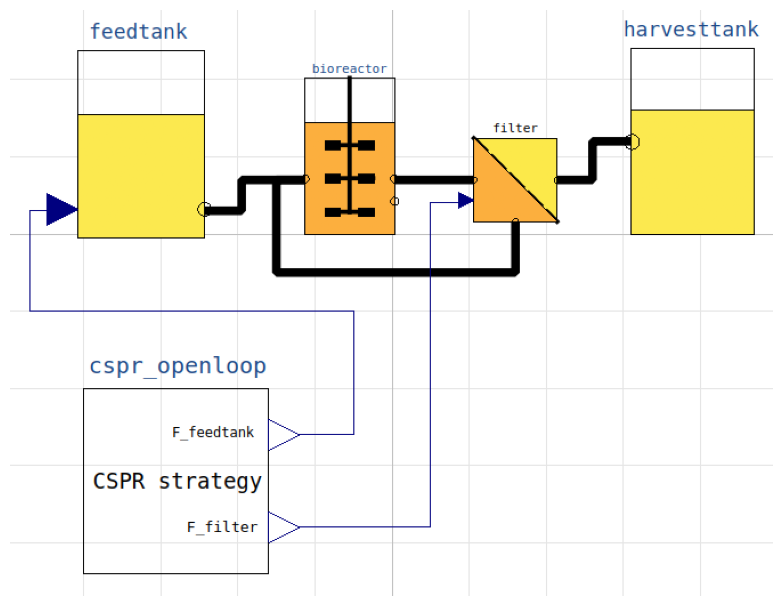

In [ ]:
process_diagram()

In [ ]:
describe('culture'); print(); #describe('liquidphase')                                  # Pump schedule parameter


Reactor culture CHO-MAb - cell line HB-58 American Culture Collection ATCC



The molecular weight of the recombinant protein (MAb) is somewhat arbitrarly chosen and the value not used in the simulations.

In [ ]:
describe('MSL')

MSL: 3.2.3 - used components: RealInput, RealOutput, CombiTimeTable, Types


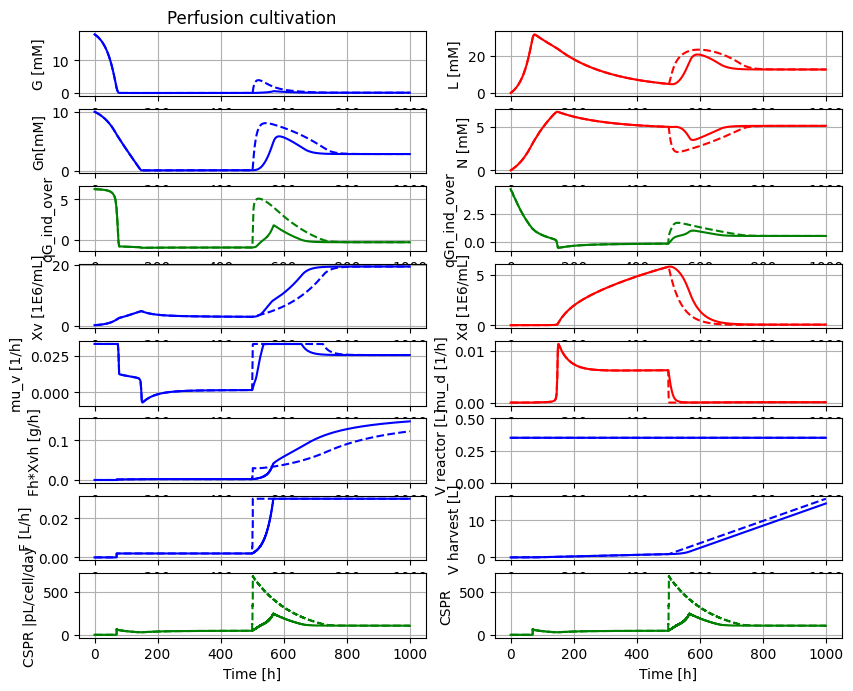

In [ ]:
newplot('Perfusion cultivation', plotType='Extended')

par(samplePeriod=1); par(F1=0.0020)              # General parameters
par(mu_ref=0.04); simu()                         # First simulation (solid)
par(mu_ref=1); simu()                            # Second simulation (dashed)

In [ ]:
model.get('CSPR')

array([105.41560997])

We see here the shorter settling time for cell conc Xv when the slower exponential increase of perfusion rate is used, compared to an abrupt change.

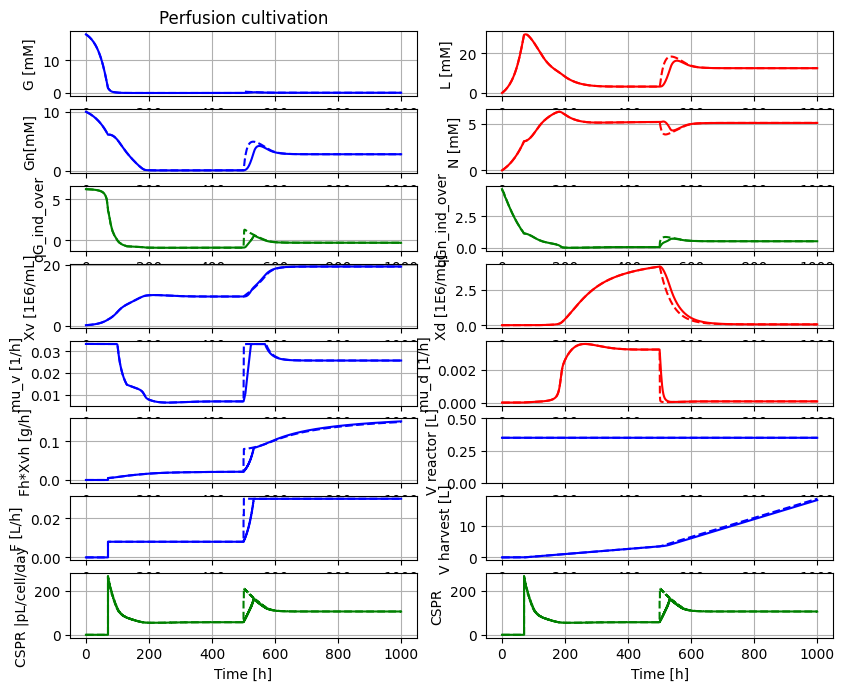

In [ ]:
newplot('Perfusion cultivation', plotType='Extended')

par(samplePeriod=1); par(F1=0.0080)               # General parameters
par(mu_ref=0.04); simu()                          # First simulation (solid)
par(mu_ref=1); simu()                             # Second simulation (dashed)

We see that a somewhat smaller change in perfusion rate make the differnce in settling time of Xv for the two strategies to almost disappear.

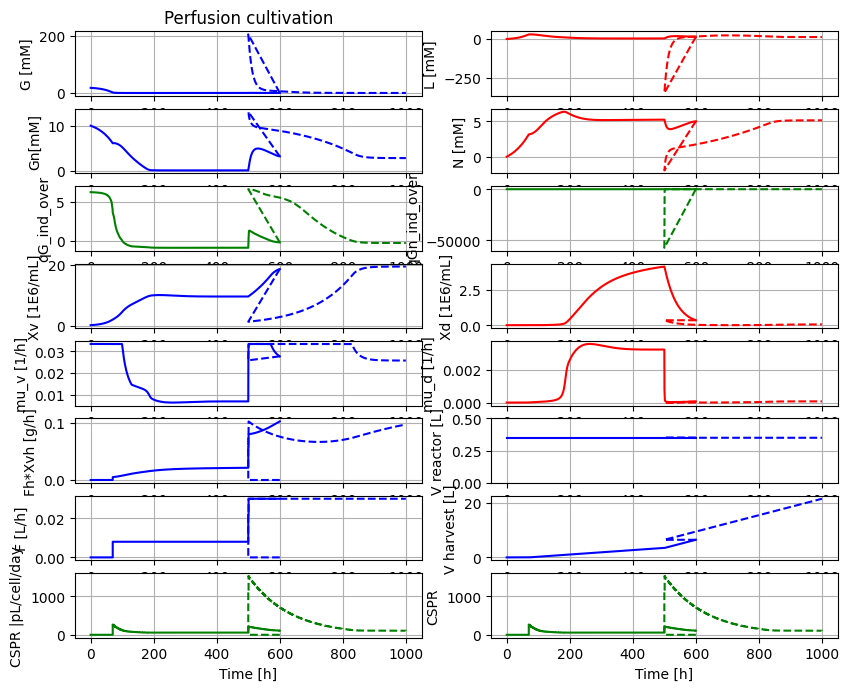

In [ ]:
newplot('Perfusion cultivation', plotType='Extended')
simu(600)
simu(400,'cont')

In [ ]:
 describe('feedtank.W')

Reactor broth weight : 78.915 [ kg ]


In [ ]:
describe('feedtank.V')

Feed volume : 78.577 [ L ]


In [ ]:
78.915/78.577

1.0043015131654303

In [ ]:
describe('bioreactor.broth_decay.k_decay')

In [ ]:
describe('k_lysis')

In [ ]:
disp('culture')

In [ ]:
describe('mu')

In [ ]:
describe('parts')

In [ ]:
describe('MSL')

In [ ]:
system_info()